In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import qgrid
from scipy.stats import fisher_exact
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests

In [3]:
wes = pd.read_csv("../../data/genomic/WES_variants_processed.csv.gz")

In [4]:
meta = pd.read_csv("../../data/E0022_P06_final_sample_map_no_control.txt", sep='\t')

# missing analysis

In [14]:
protein = pd.read_csv("../../data/protein/protein_de_processed.csv").set_index('GENE_ID')

In [29]:
genes = protein.index.values

In [30]:
def calculate_fisher(g):
    if g not in wes.columns:
        return (g, np.nan)

    wt_cell = wes[wes[g] == 0]['Cell_line'].values
    mut_cell = wes[wes[g] > 0]['Cell_line'].values

    protein_wt = protein.loc[g, wt_cell].values
    protein_mut = protein.loc[g, mut_cell].values
    wt_missing = np.sum(np.isnan(protein_wt))
    wt_nonmissing = protein_wt.size - np.sum(np.isnan(protein_wt))
    mut_missing = np.sum(np.isnan(protein_mut))
    mut_nonmissing = protein_mut.size - np.sum(np.isnan(protein_mut))
    
    wt_missing_ratio = (wt_missing+1)/protein_wt.size
    mut_missing_ratio = (mut_missing+1)/protein_mut.size
    
    mat = np.array([[wt_missing, wt_nonmissing], [mut_missing,
                                                  mut_nonmissing]])
    oddsratio, pvalue = fisher_exact(mat)
    logfc = np.log2(mut_missing_ratio/(wt_missing_ratio))
    return (g, pvalue, mut_cell.size, wt_missing_ratio, mut_missing_ratio, logfc)

In [34]:
res = Parallel(n_jobs=12)(delayed(calculate_fisher)(g) for g in tqdm(genes))

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [35]:
res_fisher_df = pd.DataFrame(res,
                      columns=[
                          'Gene', 'pvalue', 'mut_counts', 'wt_missing_ratio',
                          'mut_missing_ratio', 'logFC'
                      ]).dropna()

In [65]:
res_fisher_df.sort_values(by='adjusted.P')

,Gene,pvalue,mut_counts,wt_missing_ratio,mut_missing_ratio,logFC,-log10(P),adjusted.P,-log10(adjusted.P)
477,TP53,2.555955e-32,667.0,0.830619,0.436282,-0.928926,31.592447,8.046146e-29,28.094412
74,ARID1A,1.565721e-12,119.0,0.023392,0.210084,3.166891,11.805286,2.464444e-09,8.608281
64,DDX3X,4.708591e-09,41.0,0.003215,0.195122,5.923219,8.327109,4.940881e-06,5.306196
1462,B2M,6.923786e-09,25.0,0.307692,0.920000,1.580145,8.159656,5.449020e-06,5.263682
1065,RPL22,3.248975e-07,51.0,0.001083,0.117647,6.762724,6.488254,2.045554e-04,3.689189
...,...,...,...,...,...,...,...,...,...
1162,ECE1,4.512267e-01,19.0,0.031414,0.105263,1.744539,0.345605,1.000000e+00,-0.000000
1163,SLC1A4,3.428145e-01,9.0,0.133679,0.333333,1.318195,0.464941,1.000000e+00,-0.000000
1164,PAFAH1B1,1.000000e+00,8.0,0.034161,0.125000,1.871485,-0.000000,1.000000e+00,-0.000000
1154,RBM34,5.225462e-01,20.0,0.036688,0.100000,1.446634,0.281875,1.000000e+00,-0.000000


In [87]:
res_fisher_df['-log10(P)'] = res_fisher_df['pvalue'].map(np.log10) * -1

res_fisher_df = res_fisher_df[res_fisher_df['-log10(P)'] > 0]
res_fisher_df['adjusted.P'] = multipletests(res_fisher_df['pvalue'].values,
                                            method='fdr_bh')[1]
res_fisher_df['-log10(adjusted.P)'] = res_fisher_df['adjusted.P'].map(
    np.log10) * -1
res_fisher_df = res_fisher_df[res_fisher_df['-log10(adjusted.P)'] > 0]

<ipython-input-87-5ccaad343b4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_fisher_df['adjusted.P'] = multipletests(res_fisher_df['pvalue'].values,
<ipython-input-87-5ccaad343b4e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_fisher_df['-log10(adjusted.P)'] = res_fisher_df['adjusted.P'].map(


In [124]:
res_fisher_df.to_csv("../../plots/plot_data/Fig2D_missing_ratio_fisher.csv",
                     index=False)

In [12]:
"#{0:02x}{1:02x}{2:02x}".format(int(0.12156862745098039 * 255),
                                int(0.4666666666666667 * 255),
                                int(255 * 0.7058823529411765))

'#1f77b4'

In [13]:
"#{0:02x}{1:02x}{2:02x}".format(int(1 * 255),
                                int(0.4980392156862745 * 255),
                                int(255 * 0.054901960784313725))

'#ff7f0e'

In [14]:
"#{0:02x}{1:02x}{2:02x}".format(int(0.17254901960784313 * 255),
                                int(0.6274509803921569 * 255),
                                int(255 * 0.17254901960784313))

'#2ca02c'

In [78]:
res_fisher_df['color'] = res_fisher_df.apply(lambda row: 'nocolor'
                               if row['-log10(P)'] < 3 else 'up'
                               if row['logFC'] > 0 else 'down',
                               axis=1)

color_map = {
    'nocolor': "#1f77b4",
    'up': '#2ca02c',
    'down': '#ff7f0e'
}

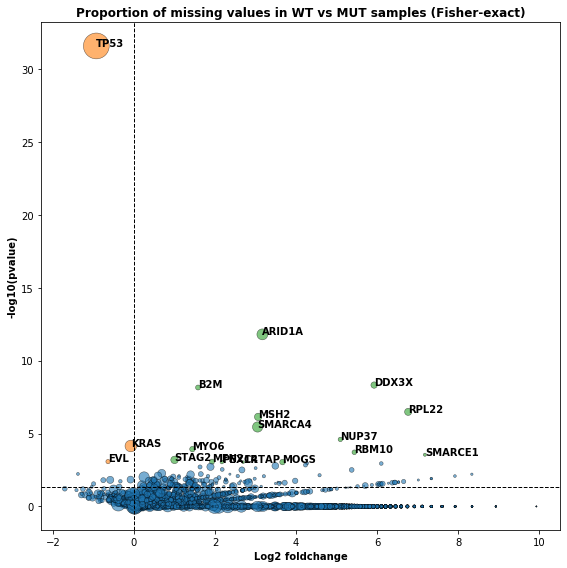

In [80]:
fig = plt.figure(figsize=[8, 8])
g = sns.scatterplot(x='logFC',
                    y='-log10(P)',
                    hue='color',
                    size='mut_counts',
                    data=res_fisher_df,
                    sizes=(res_fisher_df['mut_counts'].min(),
                           res_fisher_df['mut_counts'].max()),
                    palette=color_map,
                    alpha=0.6,
                    edgecolor='black',
                    linewidth=0.5)
for index, row in res_fisher_df.iterrows():
    if row['-log10(P)'] > 3:
        g.text(row['logFC'], row['-log10(P)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.05) * -1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("Proportion of missing values in WT vs MUT samples (Fisher-exact)",
            weight='bold')
plt.tight_layout()
plt.savefig("../../plots/landscape/missing_fisher.pdf", dpi=500)

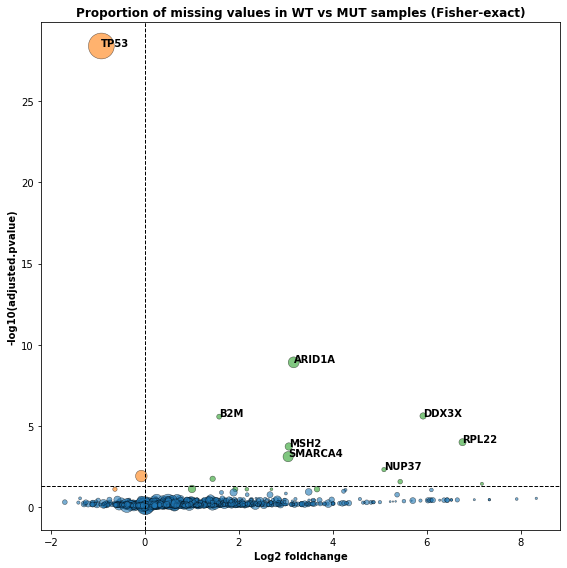

In [88]:
fig = plt.figure(figsize=[8, 8])
g = sns.scatterplot(x='logFC',
                    y='-log10(adjusted.P)',
                    hue='color',
                    size='mut_counts',
                    data=res_fisher_df,
                    sizes=(res_fisher_df['mut_counts'].min(),
                           res_fisher_df['mut_counts'].max()),
                    palette=color_map,
                    alpha=0.6,
                    edgecolor='black',
                    linewidth=0.5)
for index, row in res_fisher_df.iterrows():
    if row['-log10(adjusted.P)'] > 2:
        g.text(row['logFC'], row['-log10(adjusted.P)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(adjusted.pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.05) * -1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("Proportion of missing values in WT vs MUT samples (Fisher-exact)",
            weight='bold')
plt.tight_layout()
plt.savefig("../../plots/landscape/missing_fisher.pdf", dpi=500)

## MSI status

In [43]:
msi_cell = meta.query('MSI_status == "MSI"')['Cell_line'].unique()
mss_cell = meta.query('MSI_status == "MSS"')['Cell_line'].unique()

In [122]:
def plot_msi(res_df, gene):
    mss_missing_ratio = res_fisher_msi_df.loc[res_fisher_msi_df["Gene"] ==
                                              gene, "mss_missing_ratio"].values[0]
    msi_missing_ratio = res_fisher_msi_df.loc[res_fisher_msi_df["Gene"] ==
                                              gene, "msi_missing_ratio"].values[0]
    tmp_df = pd.DataFrame({
        'MSI_status': ['MSS', 'MSS', 'MSI', 'MSI'],
        'Missing': ['Missing', 'Non-missing', 'Missing', 'Non-missing'],
        'counts': [
            np.round(mss_missing_ratio * mss_cell.size),
            np.round((1 - mss_missing_ratio) * mss_cell.size),
            np.round(msi_missing_ratio * msi_cell.size),
            np.round((1 - msi_missing_ratio) * msi_cell.size)
        ]
    })
    sns.barplot(x='MSI_status', y='counts', hue='Missing', data=tmp_df, linewidth=2, edgecolor='black')

In [44]:
def calculate_fisher_msi(g):
    protein_mss = protein.loc[g, mss_cell].values
    protein_msi = protein.loc[g, msi_cell].values
    mss_missing = np.sum(np.isnan(protein_mss))
    mss_nonmissing = protein_mss.size - np.sum(np.isnan(protein_mss))
    msi_missing = np.sum(np.isnan(protein_msi))
    msi_nonmissing = protein_msi.size - np.sum(np.isnan(protein_msi))
    
    mss_missing_ratio = (mss_missing+1)/protein_mss.size
    msi_missing_ratio = (msi_missing+1)/protein_msi.size
    
    mat = np.array([[mss_missing, mss_nonmissing], [msi_missing,
                                                  msi_nonmissing]])
    oddsratio, pvalue = fisher_exact(mat)
    logfc = np.log2(msi_missing_ratio/(mss_missing_ratio))
    return (g, pvalue, msi_cell.size, mss_missing_ratio, msi_missing_ratio, logfc)

In [45]:
res = Parallel(n_jobs=12)(delayed(calculate_fisher_msi)(g) for g in tqdm(genes))

In [46]:
res_fisher_msi_df = pd.DataFrame(res,
                      columns=[
                          'Gene', 'pvalue', 'msi_counts', 'mss_missing_ratio',
                          'msi_missing_ratio', 'logFC'
                      ]).dropna()

In [89]:
res_fisher_msi_df['-log10(P)'] = res_fisher_msi_df['pvalue'].map(np.log10) * -1

res_fisher_msi_df = res_fisher_msi_df[res_fisher_msi_df['-log10(P)'] > 0]
res_fisher_msi_df['adjusted.P'] = multipletests(res_fisher_msi_df['pvalue'].values, method='fdr_bh')[1]
res_fisher_msi_df['-log10(adjusted.P)'] = res_fisher_msi_df['adjusted.P'].map(np.log10) * -1
res_fisher_msi_df = res_fisher_msi_df[res_fisher_msi_df['-log10(adjusted.P)'] > 0]

<ipython-input-89-72e5640f96be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_fisher_msi_df['adjusted.P'] = multipletests(res_fisher_msi_df['pvalue'].values, method='fdr_bh')[1]
<ipython-input-89-72e5640f96be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_fisher_msi_df['-log10(adjusted.P)'] = res_fisher_msi_df['adjusted.P'].map(np.log10) * -1


In [108]:
res_fisher_msi_df.sort_values('adjusted.P').head(10)

,Gene,pvalue,msi_counts,mss_missing_ratio,msi_missing_ratio,logFC,adjusted.P,-log10(P),-log10(adjusted.P),color
2168,RPL22L1,1.120141e-14,58,0.762486,0.275862,-1.466764,2.437426e-11,13.950727,10.613069,down
2547,ISOC1,6.925767e-07,58,0.439512,0.137931,-1.671954,7.535235e-04,6.159532,3.122903,down
984,MARCKS,1.336756e-06,58,0.110988,0.379310,1.772978,8.086550e-04,5.873948,3.092237,up
1168,MSH2,1.486498e-06,58,0.026637,0.206897,2.957402,8.086550e-04,5.827836,3.092237,up
2991,DCP1A,2.158341e-06,58,0.544950,0.241379,-1.174822,9.393102e-04,5.665880,3.027191,down
2988,UBE2T,4.100841e-06,58,0.478357,0.189655,-1.334710,1.135696e-03,5.387127,2.944738,down
2136,VASN,4.175352e-06,58,0.721421,0.982759,0.445996,1.135696e-03,5.379307,2.944738,up
351,PLPBP,3.402359e-06,58,0.251942,0.034483,-2.869146,1.135696e-03,5.468220,2.944738,down
1534,PPP2R2A,5.059281e-06,58,0.410655,0.137931,-1.573979,1.223222e-03,5.295911,2.912495,down
2538,PTER,7.073560e-06,58,0.451720,0.172414,-1.389555,1.539207e-03,5.150362,2.812703,down


In [91]:
res_fisher_msi_df['color'] = res_fisher_msi_df.apply(lambda row: 'nocolor'
                               if row['-log10(P)'] < 3 else 'up'
                               if row['logFC'] > 0 else 'down',
                               axis=1)

color_map = {
    'nocolor': "#1f77b4",
    'up': '#2ca02c',
    'down': '#ff7f0e'
}

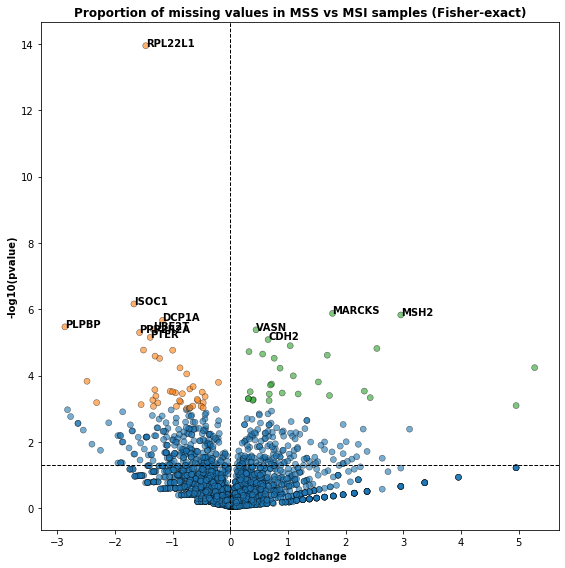

In [96]:
fig = plt.figure(figsize=[8, 8])
g = sns.scatterplot(x='logFC',
                    y='-log10(P)',
                    hue='color',
                    data=res_fisher_msi_df,
                    palette=color_map,
                    alpha=0.6,
                    edgecolor='black',
                    linewidth=0.5)
for index, row in res_fisher_msi_df.iterrows():
    if row['-log10(P)'] > 5:
        g.text(row['logFC'], row['-log10(P)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.05) * -1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("Proportion of missing values in MSS vs MSI samples (Fisher-exact)",
            weight='bold')
plt.tight_layout()
# plt.savefig("../../plots/landscape/missing_fisher.pdf", dpi=500)

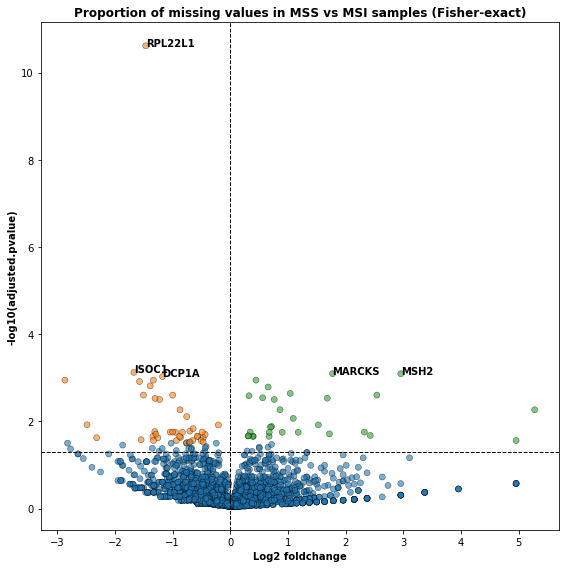

In [95]:
fig = plt.figure(figsize=[8, 8])
g = sns.scatterplot(x='logFC',
                    y='-log10(adjusted.P)',
                    hue='color',
                    data=res_fisher_msi_df,
                    palette=color_map,
                    alpha=0.6,
                    edgecolor='black',
                    linewidth=0.5)
for index, row in res_fisher_msi_df.iterrows():
    if row['-log10(adjusted.P)'] > 3:
        g.text(row['logFC'], row['-log10(adjusted.P)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(adjusted.pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.05) * -1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("Proportion of missing values in MSS vs MSI samples (Fisher-exact)",
            weight='bold')
plt.tight_layout()
# plt.savefig("../../plots/landscape/missing_fisher.pdf", dpi=500)

In [125]:
res_fisher_msi_df.to_csv("../../plots/plot_data/Fig2D_missing_ratio_fisher_MSI.csv",
                     index=False)

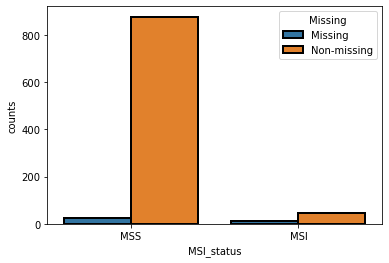

In [123]:
plot_msi(res_fisher_msi_df,"MSH2")

# replicate missing

In [3]:
meta = pd.read_csv("../../data/E0022_P06_final_sample_map_no_control.txt", sep='\t')

In [4]:
replicate = pd.read_csv("../../data/protein/protein_de_processed_rep.csv.gz").set_index('GENE_ID')

In [ ]:
msi_cell = meta[meta['MSI_status'] == 'MSI']['Cell_line'].unique()
mss_cell = meta[meta['MSI_status'] == 'MSS']['Cell_line'].unique()


In [6]:
def calculate_fisher_rep(g):
    if g not in wes.columns:
        return (g, np.nan)

    wt_cell = wes[wes[g] == 0]['Cell_line'].values
    mut_cell = wes[wes[g] > 0]['Cell_line'].values
    wt_ms = meta[meta['Cell_line'].isin(wt_cell)]['Automatic_MS_filename'].values
    mut_ms = meta[meta['Cell_line'].isin(mut_cell)]['Automatic_MS_filename'].values

    protein_wt = replicate.loc[g, wt_ms].values
    protein_mut = replicate.loc[g, mut_ms].values
    wt_missing = np.sum(np.isnan(protein_wt))
    wt_nonmissing = protein_wt.size - np.sum(np.isnan(protein_wt))
    mut_missing = np.sum(np.isnan(protein_mut))
    mut_nonmissing = protein_mut.size - np.sum(np.isnan(protein_mut))
    
    wt_missing_ratio = np.round(wt_missing/protein_wt.size, 2)
    mut_missing_ratio = np.round(mut_missing/protein_mut.size, 2)
    
    mat = np.array([[wt_missing, wt_nonmissing], [mut_missing,
                                                  mut_nonmissing]])
    oddsratio, pvalue = fisher_exact(mat)
    logfc = np.log2(mut_missing_ratio/wt_missing_ratio)
    return (g, pvalue, mut_cell.size, wt_missing_ratio, mut_missing_ratio, logfc)

In [7]:
genes = replicate.index.values

In [8]:
res = Parallel(n_jobs=12)(delayed(calculate_fisher_rep)(g) for g in tqdm(genes))

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [10]:
res_df = pd.DataFrame(res,
                      columns=[
                          'Gene', 'pvalue', 'mut_counts', 'wt_missing_ratio',
                          'mut_missing_ratio', 'logFC'
                      ]).dropna()

In [11]:
res_df['-log10(P)'] = res_df['pvalue'].map(np.log10) * -1

res_df = res_df[res_df['-log10(P)'] >=0]

In [24]:
res_df.sort_values(by='pvalue')

,Gene,pvalue,mut_counts,wt_missing_ratio,mut_missing_ratio,logFC,-log10(P)
477,TP53,1.116520e-216,667.0,0.94,0.57,-0.721699,215.952134
74,ARID1A,3.127612e-64,119.0,0.08,0.32,2.000000,63.504787
1304,SMARCA4,4.085193e-58,105.0,0.04,0.23,2.523562,57.388787
64,DDX3X,9.799113e-53,41.0,0.00,0.18,inf,52.008813
1462,B2M,2.156769e-48,25.0,0.40,0.95,1.247928,47.666196
...,...,...,...,...,...,...,...
2016,MRPL23,1.000000e+00,12.0,0.01,0.00,-inf,-0.000000
949,CAD,1.000000e+00,60.0,0.01,0.01,0.000000,-0.000000
377,PGLS,1.000000e+00,8.0,0.01,0.00,-inf,-0.000000
1499,ETF1,1.000000e+00,5.0,0.01,0.00,-inf,-0.000000


Text(0.5, 1.0, 'Proportion of missing values in WT vs MUT samples (Fisher-exact)')

posx and posy should be finite values
/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/matplotlib/transforms.py:399: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


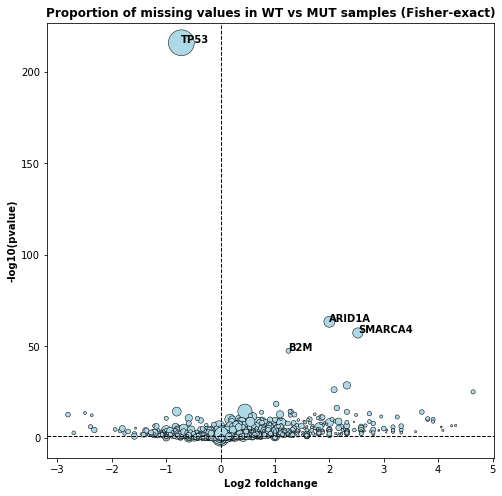

In [13]:
fig = plt.figure(figsize=[8,8])
g = sns.scatterplot(x='logFC',
                    y='-log10(P)',
                    size='mut_counts',
                    data=res_df,
                    sizes=(res_df['mut_counts'].min(), res_df['mut_counts'].max()),
                    color='lightblue',
                    edgecolor='black',
                    linewidth=0.5)
for index,row in res_df.iterrows():
    if row['-log10(P)'] > 45:
        g.text(row['logFC'],row['-log10(P)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.05)*-1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("Proportion of missing values in WT vs MUT samples (Fisher-exact)", weight='bold')

## TP53

In [20]:
gene = 'TP53'

In [21]:
mut_cell = wes[wes[gene]>0]['Cell_line']
wt_cell = wes[wes[gene]==0]['Cell_line']

In [22]:
wt_ms = meta[meta['Cell_line'].isin(wt_cell)]['Automatic_MS_filename'].values
mut_ms = meta[meta['Cell_line'].isin(mut_cell)]['Automatic_MS_filename'].values

In [30]:
protein_wt = protein.loc[gene, wt_cell].values
protein_mut = protein.loc[gene, mut_cell].values

In [45]:
protein_wt = replicate.loc[gene, wt_ms].values
protein_mut = replicate.loc[gene, mut_ms].values

In [37]:
np.nanmean(protein_wt)

-2.001906260200642

In [38]:
np.nanmean(protein_mut)

-0.7603424511574454

# RNA vs protein

In [18]:
rna_df = pd.read_csv("../../result_files/de/rna_signle.csv")
protein_df = pd.read_csv("../../result_files/de/protein_signle.csv")

In [21]:
cancer_drivers = pd.read_csv("../../data/cancer_driver.csv")['Gene'].unique()

In [19]:
rna_dep = rna_df[rna_df['adj.P.Val']<0.01].index.unique()
protein_dep = protein_df[protein_df['adj.P.Val']<0.01].index.unique()

In [25]:
genes = (set(protein_dep) - set(rna_dep)).intersection(set(cancer_drivers))

In [34]:
protein_df[protein_df.index.isin(genes)].sort_values(by='P.Value')

,logFC,AveExpr,t,P.Value,adj.P.Val,B
TP53,1.535293,-1.195651,10.006437,2.543788e-21,2.543788e-21,37.571976
RPL22,-0.453649,-0.045643,-7.600464,6.963385e-14,6.963385e-14,20.838128
ARID1A,-0.228264,0.029657,-3.761190,1.796898e-04,1.796898e-04,0.486420
PHF6,-0.630806,-0.351705,-3.479577,5.252421e-04,5.252421e-04,-0.441767
NIPBL,-0.165910,0.040816,-2.778163,5.573324e-03,5.573324e-03,-2.390485
GNA11,-0.639131,0.093634,-2.741788,6.253119e-03,6.253119e-03,-2.479709
CTNNB1,0.443735,-0.123884,2.601623,9.439015e-03,9.439015e-03,-2.797669
PPP2R1A,-0.312383,-0.190431,-2.599481,9.478010e-03,9.478010e-03,-2.801251


In [33]:
res_df[res_df['Gene'].isin(genes)].sort_values(by='pvalue')

,Gene,pvalue,mut_counts,wt_missing_ratio,mut_missing_ratio,logFC,-log10(P)
477,TP53,1.116520e-216,667.0,0.94,0.57,-0.721699,215.952134
74,ARID1A,3.127612e-64,119.0,0.08,0.32,2.000000,63.504787
1065,RPL22,1.427482e-39,51.0,0.00,0.09,inf,38.845429
985,GNA11,1.966456e-09,13.0,0.26,0.59,1.182203,8.706316
2146,NIPBL,3.699168e-09,86.0,0.06,0.13,1.115477,8.431896
2283,PHF6,4.673810e-02,11.0,0.09,0.16,0.830075,1.330329
1057,CTNNB1,1.241738e-01,42.0,0.18,0.14,-0.362570,0.905970


# DE volcano

## single proteins and rna

In [131]:
single_protein = pd.read_csv("../../result_files/de/protein_signle.csv")
single_protein.dropna().to_csv("../../result_files/de/protein_signle_nona.csv")

In [128]:
single_rna = pd.read_csv("../../result_files/de/rna_signle.csv")

## protein

In [22]:
tp53 = pd.read_csv("../../result_files/de/protein_ex/TP53_protein.csv").dropna()
tp53 = pd.read_csv("../../result_files/de/protein_ex/TP53_protein.csv").dropna()

In [23]:
tp53.index.name = 'Gene'
tp53 = tp53.reset_index()

In [24]:
tp53['-log10(FDR)'] = tp53['adj.P.Val'].map(np.log10) * -1

tp53 = tp53[tp53['-log10(FDR)'] >=0]

In [26]:
tp53.to_csv("../../plots/plot_data/Fig2C_TP53_volcano.csv", index=False)

In [20]:
tp53['color'] = tp53.apply(lambda row: 'nocolor'
                           if row['-log10(FDR)'] < 3 else 'down'
                           if row['logFC'] > 0 else 'up',
                           axis=1)
color_map = {
    'nocolor': "#1f77b4",
    'up': '#2ca02c',
    'down': '#ff7f0e'
}

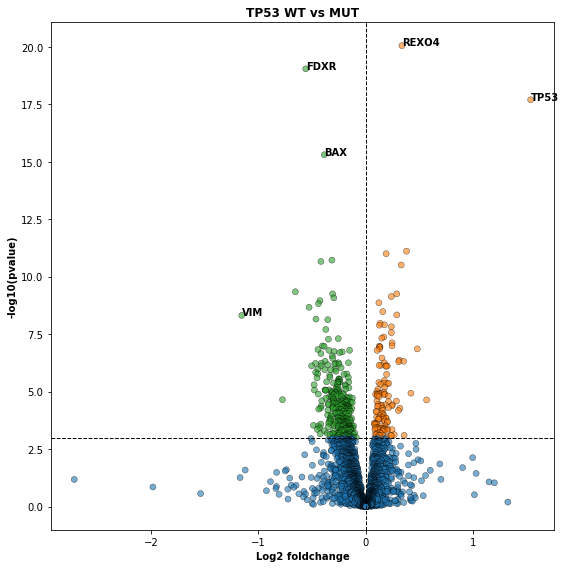

In [21]:
fig = plt.figure(figsize=[8, 8])
g = sns.scatterplot(
    x='logFC',
    y='-log10(FDR)',
    hue='color',
    palette = color_map,
    data=tp53,
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5)
for index, row in tp53.iterrows():
    if row['-log10(FDR)'] > 12 or (row['-log10(FDR)'] > 3
                                   and abs(row['logFC']) > 1):
        g.text(row['logFC'], row['-log10(FDR)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.001) * -1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("TP53 WT vs MUT", weight='bold')
plt.tight_layout()
plt.savefig("../../plots/landscape/TP53_volcano.pdf", dpi=500)

## RNA

In [42]:
tp53 = pd.read_csv("../../result_files/de/rna/TP53_rna.csv").dropna()

In [43]:
tp53.index.name = 'Gene'
tp53 = tp53.reset_index()

In [44]:
tp53['-log10(FDR)'] = tp53['adj.P.Val'].map(np.log10) * -1

tp53 = tp53[tp53['-log10(FDR)'] >=0]

In [45]:
tp53.to_csv("../../plots/plot_data/SuppFig2D_TP53_volcano_RNA.csv", index=False)

In [38]:
tp53['color'] = tp53.apply(lambda row: 'nocolor'
                           if row['-log10(FDR)'] < 3 else 'down'
                           if row['logFC'] > 0 else 'up',
                           axis=1)
color_map = {
    'nocolor': "#1f77b4",
    'down': '#2ca02c',
    'up': '#ff7f0e'
}

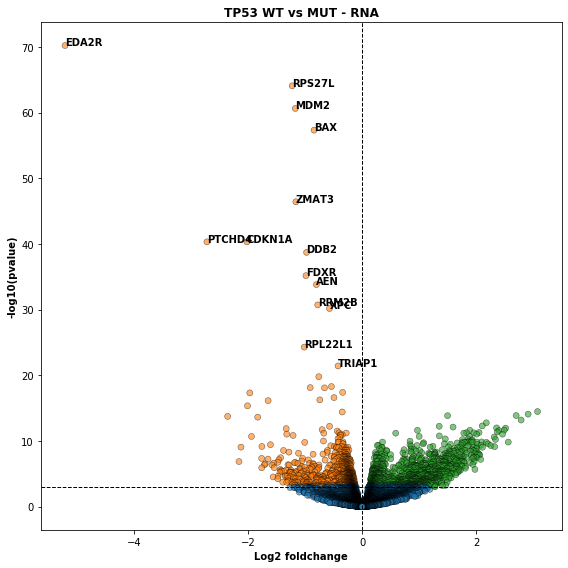

In [40]:
fig = plt.figure(figsize=[8, 8])
g = sns.scatterplot(
    x='logFC',
    y='-log10(FDR)',
    hue='color',
    palette = color_map,
    data=tp53,
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5)
for index, row in tp53.iterrows():
    if row['-log10(FDR)'] > 20:
        g.text(row['logFC'], row['-log10(FDR)'], row['Gene'], weight='bold')
g.set_xlabel('Log2 foldchange', weight='bold')
g.set_ylabel('-log10(pvalue)', weight='bold')
g.axvline(x=0, linestyle='--', linewidth=1, color='black')
g.axhline(y=np.log10(0.001) * -1, linestyle='--', linewidth=1, color='black')
g.get_legend().remove()
g.set_title("TP53 WT vs MUT - RNA", weight='bold')
plt.tight_layout()
plt.savefig("../../plots/landscape/TP53_volcano_RNA.pdf", dpi=500)